<a href="https://colab.research.google.com/github/sitikharomah/202255202001-Siti-Kharomah/blob/main/%5B3%5D_Klasifikasi_DatasetMultilabel_Telur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import keras
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.applications import MobileNetV2
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.metrics import AUC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
import os
from PIL import Image

In [40]:
import os
os.environ["KAGGLE_USERNAME"] = "skharomah" # Ganti dengan username Kaggle Anda
os.environ["KAGGLE_KEY"] = "c/content/kaggle.json" # Ganti dengan key yang ada di kaggle.json

In [41]:
!kaggle datasets download -d skharomah/klasifikasi-multilabel-telur

Dataset URL: https://www.kaggle.com/datasets/skharomah/klasifikasi-multilabel-telur
License(s): CC0-1.0
klasifikasi-multilabel-telur.zip: Skipping, found more recently modified local copy (use --force to force download)


In [42]:
# prompt: unzip file klasifikasi-multilabel-telur.zip

!unzip klasifikasi-multilabel-telur.zip


Archive:  klasifikasi-multilabel-telur.zip
replace DatasetMultilable_Siti Kharomah_202255202001/jt202505001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [46]:
#Now let us read metadata to get our Y values (multiple lables)
df = pd.read_csv('/content/traindataset_siti kharomah_202255202001.csv', sep=';')
print(df.head())     # printing first five rows of the file
print(df.columns)

# Check the number of rows in the DataFrame
num_rows = df.shape[0]
print(f"Number of rows in DataFrame: {num_rows}")

# Access a row within the valid range
if num_rows > 309:  # added condition for cases when df has less than 309 rows
  print(df.iloc[309])
else:
  print(f"Index 309 is out of bounds for DataFrame with {num_rows} rows. Try a smaller value")

            id               jenis telur  telur bebek  telur puyuh  \
0  jt202505001  telur bebek, telur ayam             1            0   
1  jt202505002  telur bebek, telur ayam             1            0   
2  jt202505003  telur bebek, telur ayam             1            0   
3  jt202505004  telur bebek, telur ayam             1            0   
4  jt202505005  telur bebek, telur ayam             1            0   

    telur ayam  telur asin  telur kampung  
0            1           0              0  
1            1           0              0  
2            1           0              0  
3            1           0              0  
4            1           0              0  
Index(['id', 'jenis telur', 'telur bebek', 'telur puyuh', ' telur ayam',
       'telur asin', 'telur kampung'],
      dtype='object')
Number of rows in DataFrame: 309
Index 309 is out of bounds for DataFrame with 309 rows. Try a smaller value


In [48]:
SIZE = 128
X_dataset = []
#Define image_directory before it's used in the loop
image_directory = '/content/DatasetMultilable_Siti Kharomah_202255202001' # Change to extracted image directory
for i in tqdm(range(df.shape[0])):
    # Assuming the column containing image file names is 'id' (lowercase)
    # Access filename using df.loc[i, 'id'] for better performance
    img = image.load_img(image_directory + '/' + df.loc[i, 'id']+'.jpg', target_size=(SIZE,SIZE,3))
    img = image.img_to_array(img)
    img = img/255.
    X_dataset.append(img)

X = np.array(X_dataset)

100%|██████████| 309/309 [00:28<00:00, 10.87it/s]


In [49]:
#
print(df['id'][256])  #telur bebek, telur puyuh, telur ayam,  telur kampung


jt202505257


In [50]:
print(df['jenis telur'][256])  #Tagged as multiple jenis telur.

telur bebek, telur puyuh, telur ayam,  telur kampung


In [51]:
#Id and Object are not labels to be trained. So drop them from the dataframe.
#No need to convert to categorical as the dataset is already in the right format.
y = np.array(df.drop(['id', 'jenis telur'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

In [57]:
# Konfigurasi
input_shape = (128, 128, 3)  # Ukuran gambar
# Change num_classes to 5 to match the number of target variables
num_classes = 5  # Ganti sesuai jumlah label kamu
multi_label = True  # True jika multi-label, False jika multi-class

# Load MobileNetV2 tanpa top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Bekukan base model agar tidak dilatih dulu
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan layer kustom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x) # Assuming you have imported Dropout from keras.layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x) # Assuming you have imported Dropout from keras.layers

# Output layer
if multi_label:
    output = Dense(num_classes, activation='sigmoid')(x)
    loss_fn = 'binary_crossentropy'
else:
    output = Dense(num_classes, activation='softmax')(x)
    loss_fn = 'categorical_crossentropy'

# Bangun model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
# Make sure you have imported AUC from tensorflow.keras.metrics
model.compile(optimizer='adam', loss=loss_fn, metrics=[AUC()])

# Ringkasan model
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [58]:
#Id and Genre are not labels to be trained. So drop them from the dataframe.
#No need to convert to categorical as the dataset is already in the right format.
y = np.array(df.drop(['id', 'jenis telur'], axis=1))

# SIZE = 128 # This line is redundant as SIZE is already defined
# X_dataset = [] # This list is redundant as it is defined in earlier cell
# image_directory = '/content/DatasetMultilable_Siti Kharomah_202255202001' # This is already defined
# for i in tqdm(range(df.shape[0])): # This loop to build X is already defined earlier
#     img = image.load_img(image_directory + '/' + df['id'][i]+'.jpg', target_size=(SIZE,SIZE,3))
#     img = image.img_to_array(img)
#     img = img/255.
#     X_dataset.append(img)
#
# X = np.array(X_dataset) #This line is redundant as X is already calculated in prior cell

# Move the data splitting line to this cell, after resizing the images:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.1)

In [59]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - auc_1: 0.5915 - loss: 0.8366 - val_auc_1: 0.8337 - val_loss: 0.4841
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc_1: 0.8570 - loss: 0.4674 - val_auc_1: 0.9591 - val_loss: 0.3324
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc_1: 0.9126 - loss: 0.3709 - val_auc_1: 0.9517 - val_loss: 0.2994
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - auc_1: 0.9417 - loss: 0.3067 - val_auc_1: 0.9751 - val_loss: 0.2372
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc_1: 0.9570 - loss: 0.2712 - val_auc_1: 0.9870 - val_loss: 0.1878
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc_1: 0.9713 - loss: 0.2228 - val_auc_1: 0.9897 - val_loss: 0.1690
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc_1: 0.9850 - loss: 0.1743 - val_auc_1: 0.9920 - val_loss: 0.1499
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc_1: 0.9829 - loss: 0.1756 - val_auc_1: 0.9818 - val_loss: 0.1772
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 

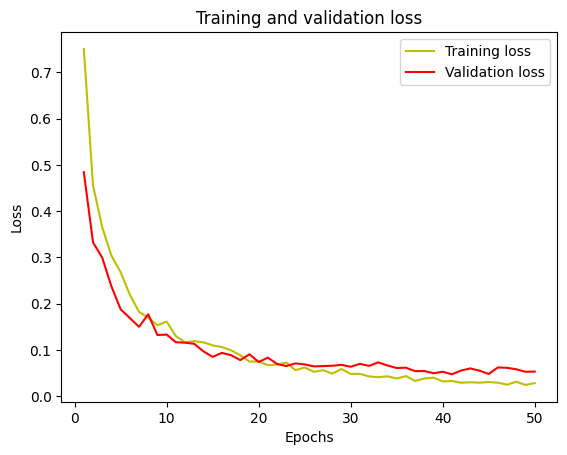

In [60]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dict_keys(['auc_1', 'loss', 'val_auc_1', 'val_loss'])


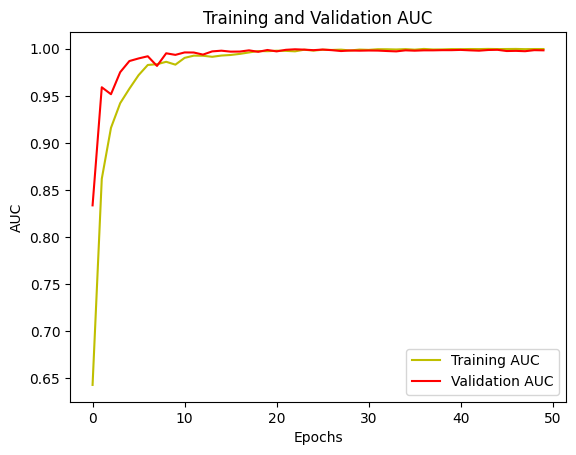

In [66]:
# Check available keys in history.history
print(history.history.keys())

# Assuming the key is 'auc_1' based on the typical naming convention
epochs = range(len(history.history['auc_1'])) # Replace 'auc' with 'auc_1'
train_auc = history.history['auc_1'] # Replace 'auc' with 'auc_1'
val_auc = history.history['val_auc_1'] # Replace 'val_auc' with 'val_auc_1'

plt.plot(epochs, train_auc, 'y', label='Training AUC')
plt.plot(epochs, val_auc, 'r', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


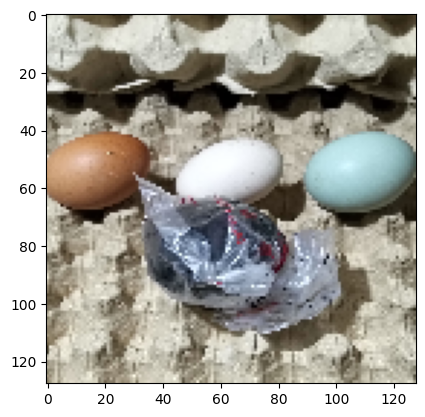

In [67]:
#Validate on an image
#img = image.load_img('/content/DatasetMultilable_Siti Kharomah_202255202001/jt202505212.jpg', target_size=(SIZE,SIZE,3))
# Assuming 'ddlj.jpg' is in '/content/DatasetMultilable_Siti Kharomah_202255202001'
img = image.load_img('/content/DatasetMultilable_Siti Kharomah_202255202001/jt202505212.jpg', target_size=(SIZE,SIZE,3))

img = image.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

classes = np.array(df.columns[2:]) #Get array of all classes
proba = model.predict(img)  #Get probabilities for each class
sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories

In [68]:
#Print classes and corresponding probabilities
for i in range(len(classes)):  # Change to iterate over the length of classes
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

telur asin (1.0)
telur kampung (0.999)
telur bebek (0.998)
 telur ayam (0.995)
telur puyuh (0.00682)


In [69]:
###################################################

_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

################################################################

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - auc: 0.9983 - loss: 0.0534
Accuracy =  99.83351826667786 %


In [70]:
# prompt: berikan code evaluasi model

from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert probabilities to class labels (e.g., using a threshold)
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming 0.5 as the threshold

# Calculate and print the classification report
print(classification_report(y_test, y_pred_classes, target_names=classes))


# Calculate and print the confusion matrix (optional)
# Note: Confusion matrices are best visualized for binary or few-class problems
# For multi-label, confusion matrix for each label is more informative
for i in range(len(classes)):
  print(f"Confusion Matrix for {classes[i]}:")
  print(confusion_matrix(y_test[:,i], y_pred_classes[:,i]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
               precision    recall  f1-score   support

  telur bebek       0.94      1.00      0.97        17
  telur puyuh       1.00      1.00      1.00        19
   telur ayam       1.00      1.00      1.00        24
   telur asin       1.00      1.00      1.00        19
telur kampung       0.96      0.96      0.96        23

    micro avg       0.98      0.99      0.99       102
    macro avg       0.98      0.99      0.99       102
 weighted avg       0.98      0.99      0.99       102
  samples avg       0.98      0.98      0.98       102

Confusion Matrix for telur bebek:
[[13  1]
 [ 0 17]]
Confusion Matrix for telur puyuh:
[[12  0]
 [ 0 19]]
Confusion Matrix for  telur ayam:
[[ 7  0]
 [ 0 24]]
Confusion Matrix for telur asin:
[[12  0]
 [ 0 19]]
Confusion Matrix for telur kampung:
[[ 7  1]
 [ 1 22]]
